In [69]:
# !pip install gym stable-baselines3 gym-anytrading
# pip install stable_baselines

In [1]:
import gym
import gym_anytrading

from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from gym_anytrading.envs import ForexEnv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from stable_baselines3 import PPO,A2C

In [3]:
df = pd.read_csv("XAUEUR_M5_202307181815_202412121430.csv",delimiter='\t')
df['Datetime'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.drop(columns=['<VOL>', '<DATE>', '<TIME>'])
df.set_index('Datetime',inplace=True)


df.rename(columns={
    '<CLOSE>': 'Close',
    '<OPEN>': 'Open',
    '<HIGH>': 'High',
    '<LOW>': 'Low',
    '<TICKVOL>': 'Volume',
    '<SPREAD>': 'Spread'
}, inplace=True)

df['SMA'] = TA.SMA(df,12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0,inplace=True)

df.dtypes


Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Spread      int64
SMA       float64
RSI       float64
OBV       float64
dtype: object

In [4]:
df

Open     High      Low    Close  Volume  Spread  \
Datetime                                                                  
2023-07-18 18:15:00  1763.68  1764.86  1763.40  1764.71     497      21   
2023-07-18 18:20:00  1764.67  1764.70  1763.28  1763.55     350      21   
2023-07-18 18:25:00  1763.50  1765.30  1763.50  1765.01     349      20   
2023-07-18 18:30:00  1764.99  1766.00  1764.50  1764.77     429      21   
2023-07-18 18:35:00  1764.80  1765.21  1763.22  1763.26     440      20   
...                      ...      ...      ...      ...     ...     ...   
2024-12-12 14:10:00  2581.77  2583.20  2581.23  2582.12     605      68   
2024-12-12 14:15:00  2582.12  2584.08  2581.22  2582.83     917      65   
2024-12-12 14:20:00  2582.83  2583.29  2581.52  2582.52    1030      65   
2024-12-12 14:25:00  2582.52  2583.55  2581.74  2581.79     689      64   
2024-12-12 14:30:00  2581.79  2582.69  2581.79  2581.98      12     103   

                             SMA        RSI       OBV  
Datetime                                               
2023-07-18 18:15:00     0.000000   0.000000       0.0  
2023-07-18 18:20:00     0.000000   0.000000    -350.0  
2023-07-18 18:25:00     0.000000  57.545045      -1.0  
2023-07-18 18:30:00     0.000000  52.224843    -430.0  
2023-07-18 18:35:00     0.000000  32.110163    -870.0  
...                          ...        ...       ...  
2024-12-12 14:10:00  2580.390833  53.827780 -375439.0  
2024-12-12 14:15:00  2580.577500  56.087160 -374522.0  
2024-12-12 14:20:00  2580.695833  54.825680 -375552.0  
2024-12-12 14:25:00  2580.890833  51.867282 -376241.0  
2024-12-12 14:30:00  2581.060833  52.584431 -376229.0  

[100000 rows x 9 columns]

In [8]:
def add_signal(env):
    start = env.frame_bound[0]-env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['Open','High','Low','Close','Volume','Spread','SMA','RSI','OBV']].to_numpy()[start:end]
    return prices,signal_features

In [28]:
class MyCustomEnv(ForexEnv):
    _process_data = add_signal

env2 = MyCustomEnv(df=df, frame_bound=(12, 80000), window_size=12)

In [5]:
env = ForexEnv(df=df, frame_bound=(5, 100), window_size=5)

In [6]:
env.action_space

Discrete(2)

info {'total_reward': -36199.951171875, 'total_profit': 0.9993503537190217, 'position': <Positions.Short: 0>}


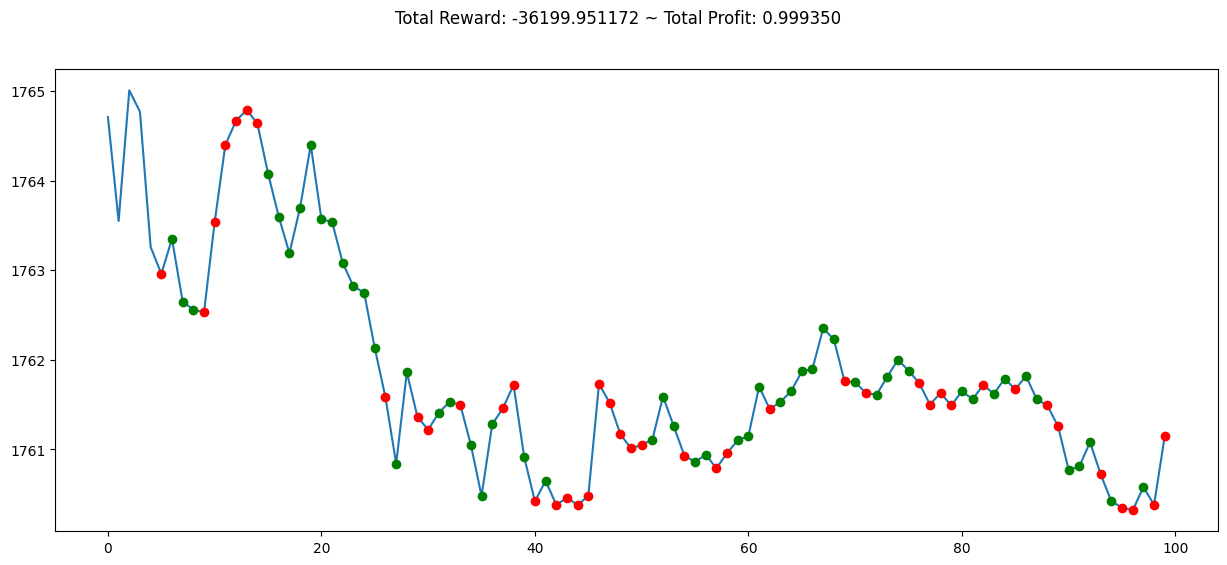

In [7]:
state = env.reset()

while True:
    action = env.action_space.sample()
    n_state, reward, done, _, info = env.step(action)
    if _:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [29]:

env_maker = lambda: env2
env= DummyVecEnv([env_maker])

In [30]:
model = A2C('MlpPolicy',env,verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 838       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.517    |
|    explained_variance | -2.87e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 2.19e+03  |
|    value_loss         | 1.82e+07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 849       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.692    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | 1.18e+0

In [73]:
print(env.action_space)

Discrete(2)


info {'total_reward': 0.0, 'total_profit': 0.9986481084828743, 'position': <Positions.Short: 0>}


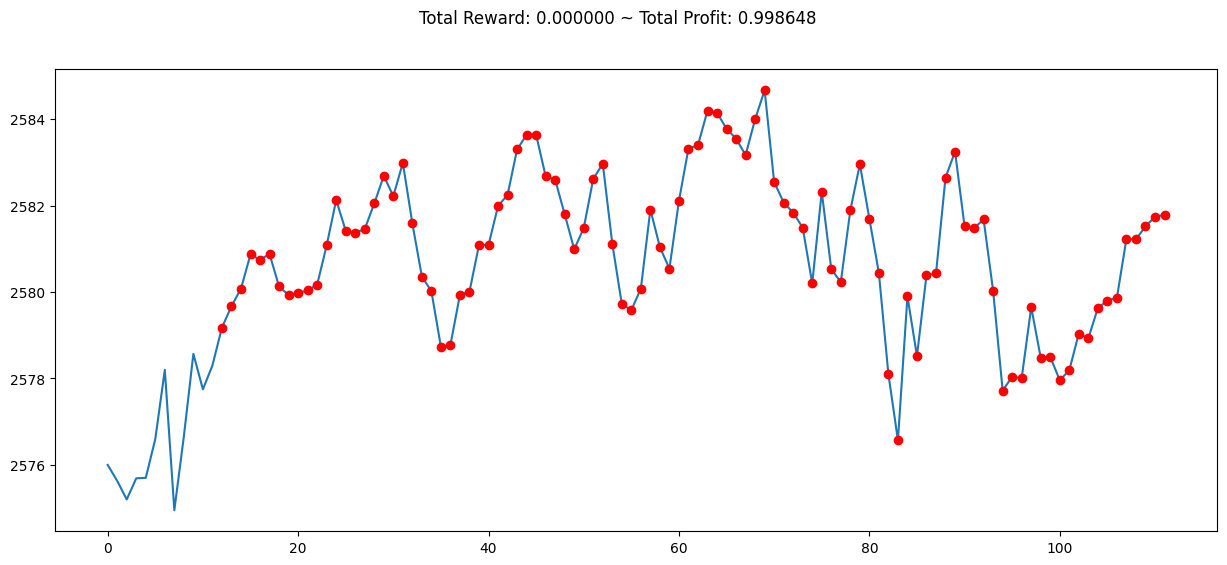

In [39]:
env = MyCustomEnv(df=df, frame_bound=(99900, 100000), window_size=12)
obs, _ = env.reset()

while True:
    action, _states = model.predict(obs)
    
    obs, reward, done, _, info = env.step(action)
    
    if _:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class TRYForexEnv(gym.Env):
    def __init__(self, df, window_size):
        super(TRYForexEnv, self).__init__()
        self.df = df
        self.window_size = window_size
        self.current_step = window_size
        self.balance = 1000  # Initial balance
        self.position = None  # None, "buy", "sell"
        self.entry_price = 0
        self.volume = 0  # New attribute to track volume
        self.trades = []

        # Action space: 0 = open buy, 1 = open sell, 2 = close buy, 3 = close sell, 4 = hold
        self.action_space = spaces.Discrete(5)

        # Observation space: [price data + indicators]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, len(df.columns)), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window_size
        self.balance = 1000
        self.position = None
        self.entry_price = 0
        self.volume = 0
        self.trades = []
        return self._get_observation()

    def step(self, action):
        done = False
        reward = 0
        current_price = self.df['Close'].iloc[self.current_step]

        if action == 0:  # Open Buy
            if self.position is None:
                self.position = "buy"
                self.entry_price = current_price
                self.volume = 1  # Start with 1 unit
                self.trades.append((self.current_step, "buy", current_price))
                print('เปิด buy 1 volume, ที่ราคา',current_price)
            elif self.position == "buy":
                # Add volume to existing buy position
                self.volume += 1
                self.entry_price = ((self.entry_price * (self.volume - 1)) + current_price) / self.volume
                self.trades.append((self.current_step, "buy", current_price))
                print('ซื้อ buy เพิ่ม เป็น',self.volume,' volume, ที่ราคา',current_price,'เฉลี่ย = ',self.entry_price)
                
            else:
                reward = -1
                #ลงโทษสำหรับ buy -> sell (ต้องปิดก่อน)
                
        elif action == 1:  # Open Sell
            if self.position is None:
                self.position = "sell"
                self.entry_price = current_price
                self.volume = 1  # Start with 1 unit
                self.trades.append((self.current_step, "sell", current_price))
                print('เปิด sell 1 volume, ที่ราคา',current_price)
            elif self.position == "sell":
                # Add volume to existing sell position
                self.volume += 1
                self.entry_price = ((self.entry_price * (self.volume - 1)) + current_price) / self.volume
                self.trades.append((self.current_step, "sell", current_price))
                print('ซื้อ sell เพิ่ม เป็น',self.volume,' volume, ที่ราคา',current_price,'เฉลี่ย = ',self.entry_price)
                
            else:
                reward = -1
                #ลงโทษสำหรับ sell -> buy (ต้องปิดก่อน)

        elif action == 2:  # Close Buy
            if self.position == "buy":
                reward = (current_price - self.entry_price) * self.volume
                self.balance += reward
                self.trades.append((self.current_step, "close_buy", current_price))
                print("ปิด buy ที่ราคา",current_price,"จำนวน",self.volume,"ได้กำไร",reward)
                print("----------------------")
                self.position = None
                self.volume = 0

        elif action == 3:  # Close Sell
            if self.position == "sell":
                reward = (self.entry_price - current_price) * self.volume
                self.balance += reward
                self.trades.append((self.current_step, "close_sell", current_price))
                print("ปิด sell ที่ราคา",current_price,"จำนวน",self.volume,"ได้กำไร",reward)
                print("----------------------")
                self.position = None
                self.volume = 0

        elif action == 4:  # Hold
            # No changes to position or balance, simply hold
            reward = -0.1

        # Update to next step
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            done = True

        obs = self._get_observation()
        info = {"balance": self.balance, "volume": self.volume}
        return obs, reward, done, info

    def _get_observation(self):
        return self.df.iloc[self.current_step - self.window_size:self.current_step].values

    def render(self):
        print(f"Step: {self.current_step}, Balance: {self.balance}, Position: {self.position}, Volume: {self.volume}")

    def plot_trades(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.df.index, self.df['Close'], label='Close Price', color='blue')

        for step, action, price in self.trades:
            if action == "buy":
                plt.scatter(self.df.index[step], price, color='green', label='Buy', marker='^')
            elif action == "sell":
                plt.scatter(self.df.index[step], price, color='pink', label='Sell', marker='v')
            elif action == "close_buy":
                plt.scatter(self.df.index[step], price, color='red', label='Close Buy', marker='o')
            elif action == "close_sell":
                plt.scatter(self.df.index[step], price, color='orange', label='Close Sell', marker='o')

        # Adjust axes for better visualization
        plt.xlim(self.df.index[0], self.df.index[-1])
        plt.ylim(self.df['Close'].min() * 0.95, self.df['Close'].max() * 1.05)

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc="upper left")

        plt.title("Forex Trading Actions")
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.grid()
        plt.show()

IndentationError: expected an indented block after 'else' statement on line 53 (801776548.py, line 55)

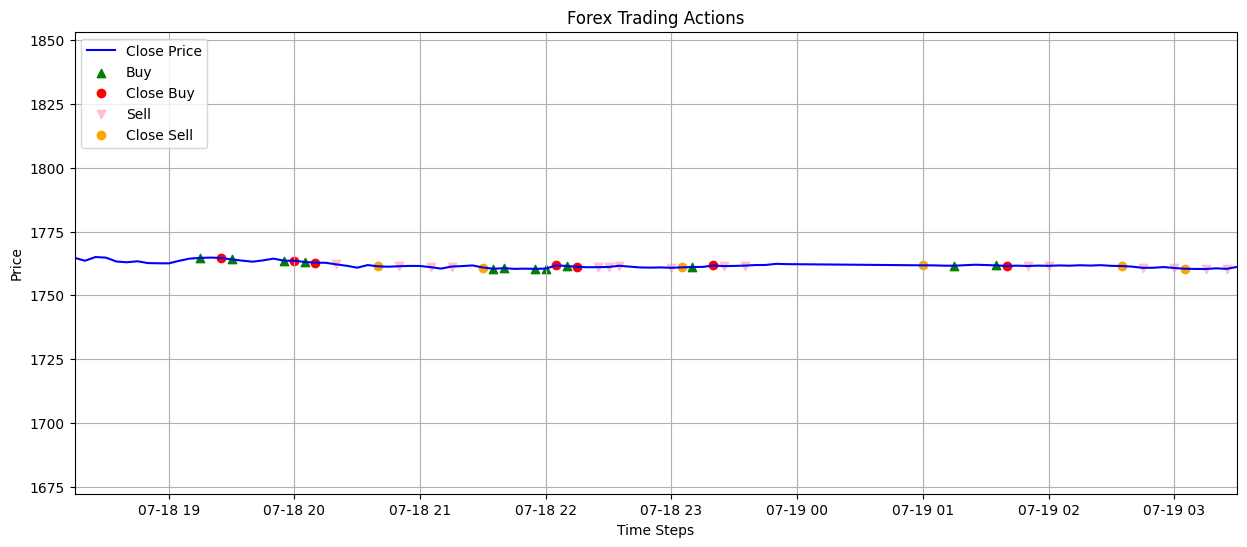

In [6]:
env = TRYForexEnv(df=df[:100], window_size=12)
obs = env.reset()

done = False
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, done, info = env.step(action)
env.plot_trades()

In [7]:
env_maker = lambda: TRYForexEnv(df=df[:80000], window_size=12)
env4= DummyVecEnv([env_maker])

C:\Users\PARADORN\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [8]:
from stable_baselines3.common.callbacks import EvalCallback


eval_callback = EvalCallback(
    env4,  # Environment สำหรับการประเมินผล
    best_model_save_path='./best_model/',  # ที่เก็บโมเดลที่ดีที่สุด
    log_path='./logs/',  # ที่เก็บ logs
    eval_freq=5000,  # ความถี่ในการประเมินผล
    deterministic=True,  # ใช้ deterministic policy
    render=False,  # ไม่ต้องแสดงการแสดงผล
)

# สร้าง PPO model
model = PPO('MlpPolicy', env4, verbose=1)

# เรียนรู้โดยใช้ eval_callback
model.learn(total_timesteps=30000, callback=eval_callback)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1344 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1019        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008638587 |
|    clip_fraction        | 0.0766      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | -0.0724     |
|    learning_rate        | 0.0003      |
|    loss                 | 3.07        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00759    |
|    value_loss           | 7.6         |
-----------------------------------------


C:\Users\PARADORN\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00
Episode length: 79987.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 8e+04       |
|    mean_reward          | 0           |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.010901772 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | -0.00129    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.59        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00628    |
|    value_loss           | 9.27        |
-----------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 27   |
|    iterations      | 3    |
|    time_elap

In [5]:
df[89900:90000]

Open     High      Low    Close  Volume  Spread  \
Datetime                                                                  
2024-10-22 14:10:00  2529.14  2529.59  2527.17  2527.44    1723      72   
2024-10-22 14:15:00  2527.38  2527.48  2525.62  2525.96    2099      72   
2024-10-22 14:20:00  2525.97  2526.82  2525.28  2525.30    1766      72   
2024-10-22 14:25:00  2525.37  2525.62  2523.63  2523.82    1403      72   
2024-10-22 14:30:00  2523.82  2525.60  2523.55  2524.69    1895      72   
...                      ...      ...      ...      ...     ...     ...   
2024-10-22 22:05:00  2541.36  2541.83  2540.90  2541.31     688      86   
2024-10-22 22:10:00  2541.36  2542.58  2541.31  2541.68     858      86   
2024-10-22 22:15:00  2541.76  2543.30  2541.68  2543.22     627      86   
2024-10-22 22:20:00  2543.30  2543.78  2542.79  2543.38     588      86   
2024-10-22 22:25:00  2543.43  2543.54  2542.70  2542.83     516      86   

                             SMA        RSI       OBV  
Datetime                                               
2024-10-22 14:10:00  2528.282500  53.028687 -251704.0  
2024-10-22 14:15:00  2528.142500  44.634018 -253803.0  
2024-10-22 14:20:00  2528.035833  41.480444 -255569.0  
2024-10-22 14:25:00  2527.828333  35.434480 -256972.0  
2024-10-22 14:30:00  2527.491667  40.888726 -255077.0  
...                          ...        ...       ...  
2024-10-22 22:05:00  2541.324167  55.695498 -241287.0  
2024-10-22 22:10:00  2541.340833  57.919806 -240429.0  
2024-10-22 22:15:00  2541.365833  65.649814 -239802.0  
2024-10-22 22:20:00  2541.508333  66.341613 -239214.0  
2024-10-22 22:25:00  2541.597500  61.738675 -239730.0  

[100 rows x 9 columns]

In [2]:
best_model = PPO.load('./best_model/best_model.zip')

เปิด buy 1 volume, ที่ราคา 2497.17
ปิด buy ที่ราคา 2497.63 จำนวน 1 ได้กำไร 0.4600000000000364
----------------------
เปิด sell 1 volume, ที่ราคา 2496.99
ซื้อ sell เพิ่ม เป็น 2  volume, ที่ราคา 2496.15 เฉลี่ย =  2496.5699999999997
ปิด sell ที่ราคา 2496.53 จำนวน 2 ได้กำไร 0.07999999999901775
----------------------
เปิด sell 1 volume, ที่ราคา 2496.3
ปิด sell ที่ราคา 2495.28 จำนวน 1 ได้กำไร 1.0199999999999818
----------------------
เปิด sell 1 volume, ที่ราคา 2493.95
ปิด sell ที่ราคา 2489.92 จำนวน 1 ได้กำไร 4.029999999999745
----------------------
เปิด sell 1 volume, ที่ราคา 2508.54
ซื้อ sell เพิ่ม เป็น 2  volume, ที่ราคา 2508.94 เฉลี่ย =  2508.74
ปิด sell ที่ราคา 2507.26 จำนวน 2 ได้กำไร 2.959999999999127
----------------------
เปิด buy 1 volume, ที่ราคา 2506.15
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 2507.76 เฉลี่ย =  2506.955
ปิด buy ที่ราคา 2507.6 จำนวน 2 ได้กำไร 1.2899999999999636
----------------------
เปิด buy 1 volume, ที่ราคา 2505.34
ซื้อ buy เพิ่ม เป็น 2  volume, ที่ราคา 2504.17 เฉ

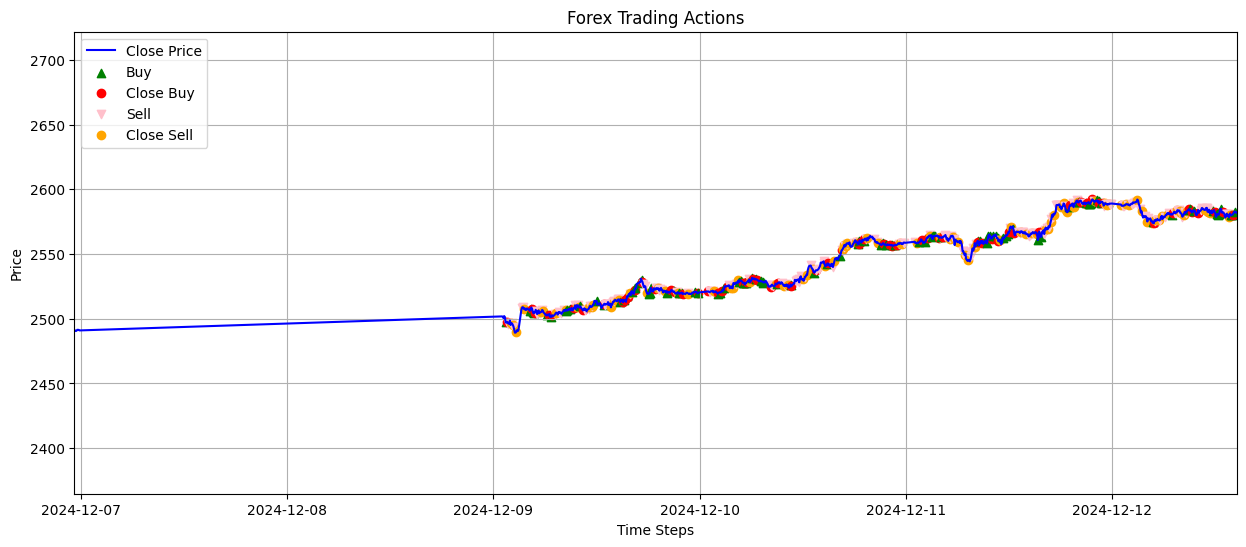

In [8]:
env = TRYForexEnv(df=df[99000:], window_size=12)
obs = env.reset()

while True:
    action, _states = best_model.predict(obs)
    
    obs, reward, done, info = env.step(action)
    
    if done:
        print("info", info)
        break
env.render()

env.plot_trades()

In [3]:
import MetaTrader5 as mt
import pandas as pd
from finta import TA
import time

mt.initialize()

# กำหนดค่าเริ่มต้น
symbol = "XAUEUR"  # สัญลักษณ์ที่ต้องการเทรด
timeframe = mt.TIMEFRAME_M5  # กรอบเวลาของข้อมูล
window_size = 24  # จำนวนแท่งเทียนที่ต้องการดึง

# ฟังก์ชันดึงข้อมูลแท่งเทียนและเพิ่มฟีเจอร์
def get_candles_with_features(symbol, timeframe, window_size):
    rates = mt.copy_rates_from_pos(symbol, timeframe, 0, window_size)
    if rates is None or len(rates) < window_size:
        print("Failed to fetch data for", symbol)
        return None
    
    # แปลงข้อมูลเป็น DataFrame
    df = pd.DataFrame(rates)
    df['Datetime'] = pd.to_datetime(df['time'], unit='s')
    df = df.drop(columns=['time', 'real_volume'])  # ลบคอลัมน์ที่ไม่ต้องการ
    df.rename(columns={
        'close': 'Close',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'tick_volume': 'Volume',
        'spread': 'Spread'
    }, inplace=True)
    df.set_index('Datetime', inplace=True)

    # เพิ่มฟีเจอร์ด้วย finta
    df['SMA'] = TA.SMA(df, 12)
    df['RSI'] = TA.RSI(df)
    df['OBV'] = TA.OBV(df)
    df.fillna(0, inplace=True)  # กรอกค่า NaN ด้วย 0
    
    return df

In [37]:
data = get_candles_with_features(symbol, timeframe, window_size)
print("Data with features 12:")
print(data[12:])

Data with features 12:
                        Open     High      Low    Close  Volume  Spread  \
Datetime                                                                  
2025-01-21 18:45:00  2630.59  2632.68  2629.84  2631.72     946      54   
2025-01-21 18:50:00  2631.68  2633.69  2631.39  2632.34     983      55   
2025-01-21 18:55:00  2632.31  2633.36  2631.23  2631.51    1064      51   
2025-01-21 19:00:00  2631.44  2632.26  2631.04  2631.95    1049      55   
2025-01-21 19:05:00  2631.93  2632.89  2631.25  2632.13     963      52   
2025-01-21 19:10:00  2632.18  2632.60  2630.65  2631.16    1075      54   
2025-01-21 19:15:00  2631.13  2631.72  2628.83  2629.16     991      71   
2025-01-21 19:20:00  2629.16  2632.12  2628.46  2631.80     803      55   
2025-01-21 19:25:00  2631.78  2632.43  2630.77  2631.57     776      56   
2025-01-21 19:30:00  2631.52  2631.52  2630.03  2631.09     687      65   
2025-01-21 19:35:00  2631.02  2631.18  2629.52  2629.56     645      62   
20

In [52]:
prediction, _ = best_model.predict(data[12:])
print("Prediction:", prediction.item())
execute_trade(2)

Prediction: 4
ปิดคำสั่ง Buy สำเร็จ, Volume: 1.0, Price: 2629.47


In [4]:
def execute_trade(action, volume=1.0):
    """
    ส่งคำสั่งซื้อขายจริงผ่าน MetaTrader 5 ตาม Action ที่ได้รับ:
    0 = Open Buy
    1 = Open Sell
    2 = Close Buy
    3 = Close Sell
    4 = Hold
    """
    price = mt.symbol_info_tick(symbol)
    if not price:
        print(f"ไม่พบข้อมูลราคา Symbol: {symbol}")
        return None

    # ตรวจสอบสถานะปัจจุบันของ position
    current_position = None
    positions = mt.positions_get(symbol=symbol)
    if positions:
        current_position = "buy" if positions[0].type == mt.ORDER_TYPE_BUY else "sell"
        current_volume = positions[0].volume
        entry_price = positions[0].price_open
    else:
        current_volume = 0
        entry_price = 0

    if action == 0:  # Open Buy
        if current_position is None:
            # เปิด buy ครั้งแรก
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_BUY,
                "price": price.ask,
                "deviation": 10,
                "magic": 123456,
                "comment": "Open Buy Order",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"เปิด buy 1 volume, ที่ราคา {price.ask}")
        elif current_position == "buy":
            # เพิ่ม buy volume
            new_volume = current_volume + volume
            entry_price = ((entry_price * current_volume) + (price.ask * volume)) / new_volume
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_BUY,
                "price": price.ask,
                "deviation": 10,
                "magic": 123456,
                "comment": "Add Buy Volume",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"ซื้อ buy เพิ่ม เป็น {new_volume} volume, ที่ราคา {price.ask}, เฉลี่ย = {entry_price}")
        else:
            print("ไม่สามารถเปิด buy ได้ เนื่องจากสถานะปัจจุบันเป็น sell")

    elif action == 1:  # Open Sell
        if current_position is None:
            # เปิด sell ครั้งแรก
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_SELL,
                "price": price.bid,
                "deviation": 10,
                "magic": 123456,
                "comment": "Open Sell Order",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"เปิด sell 1 volume, ที่ราคา {price.bid}")
        elif current_position == "sell":
            # เพิ่ม sell volume
            new_volume = current_volume + volume
            entry_price = ((entry_price * current_volume) + (price.bid * volume)) / new_volume
            request = {
                "action": mt.TRADE_ACTION_DEAL,
                "symbol": symbol,
                "volume": volume,
                "type": mt.ORDER_TYPE_SELL,
                "price": price.bid,
                "deviation": 10,
                "magic": 123456,
                "comment": "Add Sell Volume",
                "type_time": mt.ORDER_TIME_GTC,
                "type_filling": mt.ORDER_FILLING_IOC,
            }
            result = mt.order_send(request)
            print(f"ซื้อ sell เพิ่ม เป็น {new_volume} volume, ที่ราคา {price.bid}, เฉลี่ย = {entry_price}")
        else:
            print("ไม่สามารถเปิด sell ได้ เนื่องจากสถานะปัจจุบันเป็น buy")

    elif action == 2:  # Close Buy
        if current_position == "buy":
            for pos in positions:
                if pos.type == mt.ORDER_TYPE_BUY:
                    request = {
                        "action": mt.TRADE_ACTION_DEAL,
                        "symbol": symbol,
                        "volume": pos.volume,
                        "type": mt.ORDER_TYPE_SELL,
                        "price": price.bid,
                        "deviation": 10,
                        "magic": 123456,
                        "comment": "Close Buy Position",
                        "type_time": mt.ORDER_TIME_GTC,
                        "type_filling": mt.ORDER_FILLING_IOC,
                        "position": pos.ticket,
                    }
                    result = mt.order_send(request)
                    if result.retcode == mt.TRADE_RETCODE_DONE:
                        print(f"ปิดคำสั่ง Buy สำเร็จ, Volume: {pos.volume}, Price: {price.bid}")
                    else:
                        print(f"ปิดคำสั่ง Buy ล้มเหลว, Retcode: {result.retcode}, Error: {mt.last_error()}")
        else:
            print("ไม่มีสถานะ Buy ที่จะปิดได้")

    elif action == 3:  # Close Sell
        if current_position == "sell":
            for pos in positions:
                if pos.type == mt.ORDER_TYPE_SELL:
                    request = {
                        "action": mt.TRADE_ACTION_DEAL,
                        "position": pos.ticket,
                        "symbol": symbol,
                        "volume": pos.volume,
                        "type": mt.ORDER_TYPE_BUY,
                        "price": price.ask,
                        "deviation": 10,
                        "magic": 123456,
                        "comment": "Close Sell Position",
                        "type_time": mt.ORDER_TIME_GTC,
                        "type_filling": mt.ORDER_FILLING_IOC,
                    }
                    result = mt.order_send(request)
                    print(f"ปิดคำสั่ง Sell, Volume: {pos.volume}, Price: {price.ask}, Result: {result.retcode}")
        else:
            print("ไม่มีสถานะ Sell ที่จะปิดได้")

    elif action == 4:  # Hold
        print("Hold: ไม่ทำการส่งคำสั่ง")


In [ ]:
# ตัวอย่างการใช้งาน
def main():
    while True:
        # ดึงข้อมูลพร้อมฟีเจอร์
        data = get_candles_with_features(symbol, timeframe, window_size)
        if data is None:
            time.sleep(300)  # รอ 5 นาทีหากดึงข้อมูลล้มเหลว
            continue

        print("Data with features 12:")
        print(data[12:])  # แสดงแท่งเทียนล่าสุด 5 แท่ง

        prediction, _ = best_model.predict(data[12:])
        print("Prediction:", prediction.item())
        execute_trade(prediction.item())
        time.sleep(300)

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("Terminating program")

Data with features 12:
                        Open     High      Low    Close  Volume  Spread  \
Datetime                                                                  
2025-01-21 20:35:00  2630.34  2631.80  2630.24  2630.91     623      59   
2025-01-21 20:40:00  2630.91  2631.36  2630.08  2630.88     514      62   
2025-01-21 20:45:00  2631.07  2631.35  2630.26  2630.85     587      60   
2025-01-21 20:50:00  2630.80  2631.29  2630.36  2631.08     585      65   
2025-01-21 20:55:00  2631.07  2631.55  2630.70  2631.30     738      53   
2025-01-21 21:00:00  2631.18  2631.85  2630.37  2630.91     729      52   
2025-01-21 21:05:00  2630.56  2631.88  2630.22  2631.43     657      65   
2025-01-21 21:10:00  2631.43  2631.49  2630.31  2630.86     677      59   
2025-01-21 21:15:00  2630.46  2630.93  2629.69  2630.41     776      44   
2025-01-21 21:20:00  2630.43  2631.06  2629.38  2630.47     908      44   
2025-01-21 21:25:00  2630.16  2631.45  2630.12  2631.14     649      43   
20

In [ ]:
import zmq

def main():
    # สร้าง ZeroMQ context
    context = zmq.Context()
    
    # สร้าง socket แบบ REP (Reply)
    socket = context.socket(zmq.REP)
    socket.bind("tcp://*:5555")  # ฟังที่พอร์ต 5555
    
    print("Python Server: Waiting for messages...")
    while True:
        # รับข้อความจาก MT5
        message = socket.recv()  # รับข้อมูลเป็นไบต์
        print(f"Received: {message.decode()}")  # แปลงข้อมูลเป็น string และพิมพ์ออกมา

        socket.send_string("Message received")
if __name__ == "__main__":
    main()

Python Server: Waiting for messages...
